In [2]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'daseCV/assignments/assignment3/'
FOLDERNAME = 'assignment3/assignment3-vanilla'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/daseCV/datasets/
!bash get_datasets.sh
%cd /content

Mounted at /content/drive
/content/drive/My Drive/assignment3/assignment3-vanilla/daseCV/datasets
/content


# Generative Adversarial Networks (GANs)
到目前为止，我们探索的神经网络的所有应用都是**区分模型**，它们接受输入并经过训练以产生标签输出。 他们的范围从图像类别的直接分类到句子生成（这一直被称为分类问题，我们的标签在词汇空间中，并且我们学会了用循环去捕获多词标签）。 在该 notebook 中，我们将扩展功能范围，并使用神经网络构建**生成模型**。 具体来说，我们将学习如何构建模型，以生成一张全新的图片（注意 GAN 无法生成没见过的元素，换句话说 GAN 生成的所谓的全新的图片是训练集图片的某种重组）。


### What is a GAN?

2014年的时候 [Goodfellow et al.](https://arxiv.org/abs/1406.2661) 提出了一种用于训练生成模型的方法，称为生成对抗网络（简称GAN）。在 GAN 里面我们构建了两种神经网络。第一个网络是一个传统的分类网络名为 **判别器（discriminator）** 。我们会训练判别器让它将输入图片分类为两个类别：真实的（属于训练集）或伪造的（不在训练集中）。另一个网络为 **生成器（generator）**，它接受噪声作为输入然后用一个神经网络去将其转换成图片。生成器的目的是使判别器误以为生成器生成的图像是真实的。

我们可以将生成器 ($G$) 试图欺骗判别器 ($D$) 以及判别器试图区分图片为真实还是假冒的这种来回过程视为minimax游戏：

$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

其中 $z \sim p(z)$ 为随机噪声样本， $G(z)$ 为用神经网络生成器 $G$ 生成的图片， $D$ 为判别器的输出结果它能告诉我们输入图片为真实图片的概率。在 [Goodfellow et al.](https://arxiv.org/abs/1406.2661) 中，他们分析了这个minimax游戏，并展示了它是如何最小化训练集的数据分布和 $G$ 生成的样本之间的Jensen-Shannon divergence（JS散度）的。

为了优化此minimax游戏，我们将交替在目标 $G$ 上执行梯度*下降*步骤，并在目标 $D$ 上执行梯度*上升*步骤：
- 1.更新 **生成器** ($G$) 以最小化__判别器做出正确选择__的可能性。（更新生成器执行梯度*下降*让判别器误判）
- 2.更新 **判别器** ($D$) 以最大化__判别器做出正确选择__的可能性。（更新判别器执行梯度*上升*让判别器正判）

这些更新在分析时很有用，但在实践中却效果不佳。相反的，当更新生成器时，我们将使用一个不同的优化目标：最大化**判别器做出错误选择**的可能性。当判别器非常“自信”的时候，这个小的改动有助于消除生成器存在的梯度消失的问题。这就是大多数 GAN 的文章中会使用的标准更新策略，此外原文中也是这么用的 [Goodfellow et al.](https://arxiv.org/abs/1406.2661)。

在该作业中，我们会交替进行以下步骤：
- 1.更新 **生成器** ($G$) 以最大化__判别器对生成图片做出错误选择__的可能性：
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
- 2.更新 **判别器** ($D$) 以最大化__判别器对生成图片做出正确选择__的可能性。
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
自2014年以来，GAN 成为了一个庞大的研究领域，拥有大量的 [讲习班](https://sites.google.com/site/nips2016adversarial/) 和 [数百篇新论文](https://github.com/hindupuravinash/the-gan-zoo)。其它的生成模型的方法通常可以生成高质量的样本，但它们的模型往往很难训练（请参阅[该 github 仓库](https://github.com/soumith/ganhacks)，其中包含一组17个技巧，它们对于使模型的正常工作非常有用）。提高 GAN 训练的稳定性和鲁棒性是一个开放的研究问题，每天都有新论文出现！有关GAN的最新教程，[看这里](https://arxiv.org/abs/1701.00160)。最近还有一些激动人心的工作，将目标函数更改为Wasserstein距离，使得模型体系结构之间产生了更加稳定的结果：[WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028)。

GAN 不是训练生成模型的唯一方法！有关生成模型的其他方法，请查看 [《深度学习》](http://www.deeplearningbook.org) 一书的 [深入生成模型一章](http://www.deeplearningbook.org/contents/generative_models.html)。训练神经网络作为生成模型的另一种流行方式是变分自编码器( [这里](https://arxiv.org/abs/1312.6114) 跟 [这里](https://arxiv.org/abs/1401.4082) 同时发现了这点)。变分自编码器将神经网络与变分推理相结合，以训练深度生成模型。 这些模型往往更稳定且更易于训练，但目前无法生成像 GAN 一样漂亮的样本。

下面的示例，展示了3种不同模型的输出会是什么样的...请注意，GAN 有时会有些挑剔，因此你的输出可能看起来并不完全像这样...示例图意味着你可以*大概*的期望模型会有什么样子的输出：

![caption](gan_outputs_pytorch.png)


## Setup

In [3]:
import tensorflow as tf
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

from daseCV.gan_tf import preprocess_img, deprocess_img, rel_error, count_params, MNIST



NOISE_DIM = 96

In [4]:
# Colab users only
%cd drive/My\ Drive/$FOLDERNAME/
%cp -r gan-checks-tf.npz /content/
%cd /content/

/content/drive/My Drive/assignment3/assignment3-vanilla
/content


In [5]:
answers = np.load('gan-checks-tf.npz')

## Dataset
众所周知，GAN 对超参数非常挑剔，并且还需要对数据训练许多回合。为了使该作业在没有 GPU 的情况下可以被完成，我们将使用 MNIST 数据集，该数据集有60,000张训练图像和10,000张测试图像。每张图片的背景为黑色，内容为0到9之间的的数字。这是用于训练卷积神经网络的最早的那批数据集之一，而且数据集非常简单————标准的 CNN 模型可以轻松达到99％的准确率。
 
**Heads-up**：我们的 MNIST 包装类将图片返回为向量。也就是说返回的 size 为 (batch, 784)。如果你想将他们看成图片那么我们不得不将他们 resize 成 (batch,28,28) 或者 (batch,28,28,1)。同时他们的类型为 np.float32 取值范围是 `[0,1]`。

11501568/11490434 [==============================] - 0s 0us/step


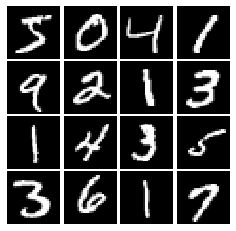

In [6]:
# show a batch
mnist = MNIST(batch_size=16) 
show_images(mnist.X[:16])

## LeakyReLU
在下面的单元格中，你需要实现一个 LeakyReLU。查看 [课程笔记](http://cs231n.github.io/neural-networks-1/)（其中的 alpha 是一个很小的数） 或者 [这篇文章](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf) 中的公式(3)。LeakyReLUs 能够防止 ReLU 单元“死亡”因此 GAN 中常常会使用这种激活函数（就如 maxout 单元这种方法会增加模型尺寸，因此该 notebook 中不会使用这种方法）。

HINT: 你需要使用 `tf.maximum`

在 `daseCV/gan_tf.py` 中实现 `leaky_relu` 函数

测试你的 leaky ReLU，错误需要小于1e-10

In [13]:
from daseCV.gan_tf import leaky_relu

def test_leaky_relu(x, y_true):
    y = leaky_relu(tf.constant(x))
    print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
生成 TensorFlow `Tensor` 内容为从-1到1之间（边界不用管）均匀分布的噪声，噪声的 shape 为 `[batch_size, dim]` 。

`sample_noise` 在 `daseCV/gan_tf.py` 中实现 `sample_noise` 函数

确保生成的噪声的 shape 跟 type 是正确的：

In [14]:
from daseCV.gan_tf import sample_noise

def test_sample_noise():
    batch_size = 3
    dim = 4
    z = sample_noise(batch_size, dim)
    # Check z has the correct shape
    assert z.get_shape().as_list() == [batch_size, dim]
    # Make sure z is a Tensor and not a numpy array
    assert isinstance(z, tf.Tensor)
    # Check that we get different noise for different evaluations
    z1 = sample_noise(batch_size, dim)
    z2 = sample_noise(batch_size, dim)
    assert not np.array_equal(z1, z2)
    # Check that we get the correct range
    assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
    print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
我们的第一步就是构建一个判别器。**Hint:** 你需要将网络写到 `tf.keras.layers` 里面去构建模型。所有的全连接（FC）层都要包括偏置项。在初始化的时候直接使用 `tf.keras.layers` 函数的初始值。

模型结构:
 * FC层，输入尺寸：784，输出尺寸：256
 * LeakyReLU，alpha：0.01
 * FC层，输入尺寸：256，输出尺寸：256
 * LeakyReLU，alpha：0.01
 * FC层，输入尺寸：256，输出尺寸：1
 
判别器的输出 shape 为  `[batch_size, 1]`，每行的实数值表示该图片被预测为真实图片的得分（score）。

在 `daseCV/gan_tf.py` 中完成 `discriminator()` 函数

确保判别器中的参数个数是正确的：

In [15]:
from daseCV.gan_tf import discriminator

def test_discriminator(true_count=267009, discriminator=discriminator):
    model = discriminator()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
    else:
        print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
现在构建生成器网络。 用 `tf.keras.layers` 构建网络。所有的全连接（FC）层都要包括偏置项。你可以通过 `tf.nn` 模块去使用激活函数。 再次强调对于参数使用默认初始值就好。

网络结构:
 * FC层，输入尺寸： tf.shape(z)\[1\] (the number of noise dimensions)，输出尺寸：1024
 * `ReLU`
 * FC层，尺寸：1024
 * `ReLU`
 * FC层，尺寸：784
 * `TanH` (将图片像素值范围缩放为 `(-1,1)`)
 
在 `daseCV/gan_tf.py` 中完成 `generator()` 函数

测试结果以确保生成器中的参数数量正确：

In [16]:
from daseCV.gan_tf import generator

def test_generator(true_count=1858320, generator=generator):
    model = generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
    else:
        print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

计算生成器跟判别器的损失。生成器的损失为：
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
判别器的损失为：
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
请注意，这里的公式与先前的公式相比多了个负号，因为在这里我们的目标是*最小化*这些损失。

**HINTS**: Use [tf.ones](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/ones) and [tf.zeros](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/zeros) to generate labels for your discriminator（判别器）. Use [tf.keras.losses.BinaryCrossentropy](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/losses/BinaryCrossentropy) to help compute your loss function.

在 `daseCV/gan_tf.py` 中完成 `discriminator_loss, generator_loss` 函数

测试你的 GAN 损失。确保生成器跟判别器的损失都为正确。错误应小于1e-8。


In [17]:
from daseCV.gan_tf import discriminator_loss

def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(tf.constant(logits_real),
                                tf.constant(logits_fake))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

test_discriminator_loss(answers['logits_real'], answers['logits_fake'],
                        answers['d_loss_true'])

Maximum error in d_loss: 6.02597e-17


In [18]:
from daseCV.gan_tf import generator_loss

def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(tf.constant(logits_fake))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(answers['logits_fake'], answers['g_loss_true'])

Maximum error in g_loss: 7.19722e-17


# Optimizing our loss
将 `Adam` 优化器的学习率设置为1e-3， beta1=0.5。用它去最小化 G_loss 和 D_loss。 [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) 这篇文章中发现减少 beta 能帮助 GANs 更好地收敛。事实上，如果使用现在的超参数，如果你使用 Tensorflow 的默认设置将 beta1 设置为0.9那么你的判别器损失很可能会下降到0并且生成器将完全无法学习。事实上在 GANs 里面这是一个很普遍的失败原因；如果你的 D(x) 学的太快（例如损失下降到接近于0），你的 G(z) 就再也不可能学习到东西。通常 D(x) 都用Momentum 或者 RMSProp 进行优化而不是使用 Adam 来优化，但是这里我们用 Adam 去优化 D(x) 跟 G(z) 。

在 `daseCV/gan_tf.py` 中完成 `get_solvers` 函数

In [19]:
from daseCV.gan_tf import get_solvers

# Training a GAN!
好吧，这并不难，不是吗？ 在训练第一个回合后，你会看到模糊的外形，当你快要训练到第三个回合的时候会看到清晰不错的形状，当我们迭代超过五回合时，其中大约一半的内容将变得清晰可见。在我们的例子中，每次迭代仅用一批数据去训练 D(x) 和 G(z)。然而在不同的文章中会使用不同的策略去训练 D(x) 跟 G(z)，有时我们会拎出一批数据让它多训练好几步，甚至一直用一批数据去训练直到损失足够小才换成其他数据。

**如果你是 Colab 用户，记住将 colab 的 runtime 改成 GPU。**

#### 训练你的 GAN！如果使用 CPU 会耗时10分钟，如果用 GPU 将耗时2分钟。

In [20]:
from daseCV.gan_tf import run_a_gan

# Make the discriminator
D = discriminator()

# Make the generator
G = generator()

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver, G_solver = get_solvers()

# Run it!
images, final = run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss)

Epoch: 0, Iter: 0, D: 1.608, G:0.7449
Instructions for updating:
Use tf.identity instead.
Epoch: 0, Iter: 250, D: 0.7372, G:1.901
Epoch: 1, Iter: 500, D: 1.139, G:1.532
Epoch: 1, Iter: 750, D: 0.8899, G:1.865
Epoch: 2, Iter: 1000, D: 0.7801, G:0.965
Epoch: 2, Iter: 1250, D: 1.412, G:1.004
Epoch: 3, Iter: 1500, D: 1.111, G:1.124
Epoch: 3, Iter: 1750, D: 1.199, G:1.047
Epoch: 4, Iter: 2000, D: 1.462, G:0.936
Epoch: 4, Iter: 2250, D: 1.302, G:0.795
Epoch: 5, Iter: 2500, D: 1.278, G:0.8013
Epoch: 5, Iter: 2750, D: 1.392, G:0.8584
Epoch: 6, Iter: 3000, D: 1.549, G:0.6851
Epoch: 6, Iter: 3250, D: 1.352, G:0.9994
Epoch: 7, Iter: 3500, D: 1.342, G:0.834
Epoch: 7, Iter: 3750, D: 1.369, G:0.8126
Epoch: 8, Iter: 4000, D: 1.337, G:0.8421
Epoch: 9, Iter: 4250, D: 1.368, G:0.8292
Epoch: 9, Iter: 4500, D: 1.31, G:0.9126


Iter: 0


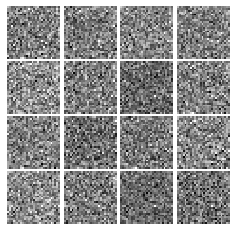


Iter: 20


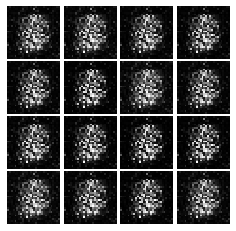


Iter: 40


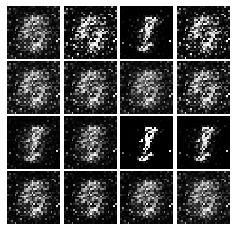


Iter: 60


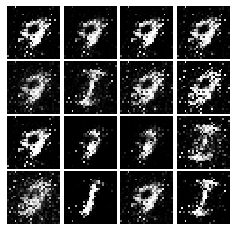


Iter: 80


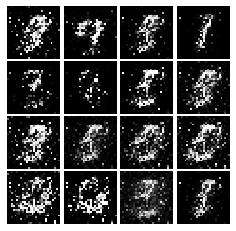


Iter: 100


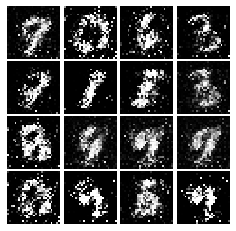


Iter: 120


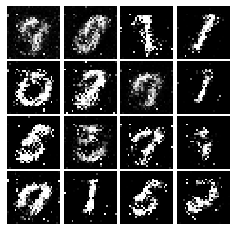


Iter: 140


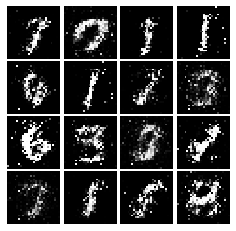


Iter: 160


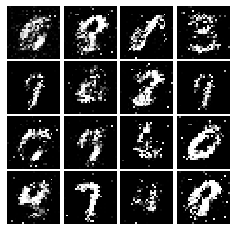


Iter: 180


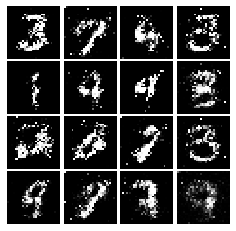


Iter: 200


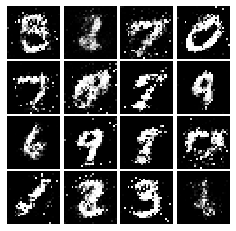


Iter: 220


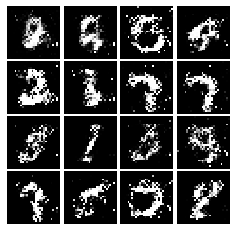


Iter: 240


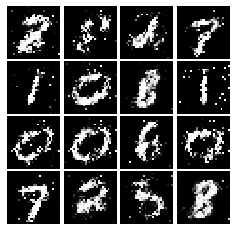


Iter: 260


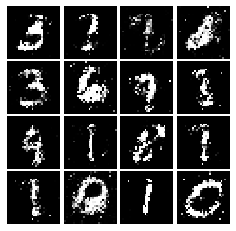


Iter: 280


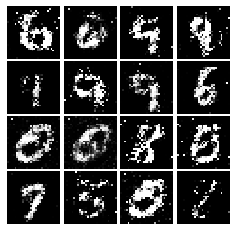


Iter: 300


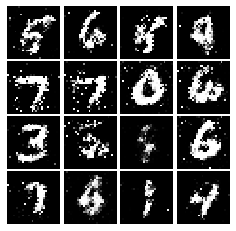


Iter: 320


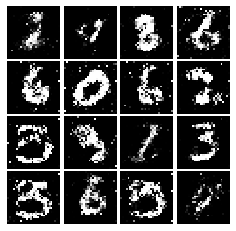


Iter: 340


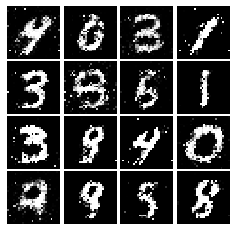


Iter: 360


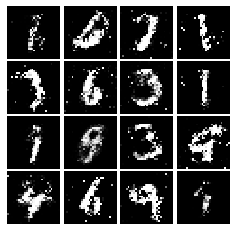

In [21]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 20
    print()
    


**提交时，请运行下面的单元格。**

Vanilla GAN Final images


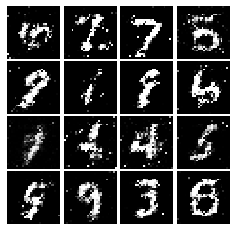

In [22]:
print('Vanilla GAN Final images')
show_images(final)
plt.show()

# Least Squares GAN
现在我们来看一下 [Least Squares GAN](https://arxiv.org/abs/1611.04076)，一种新的更稳定的对原先 GAN 损失函数优化的方法（[中文解析](https://blog.csdn.net/cuihuijun1hao/article/details/83114145)）。这部分我们只要改变原有的损失函数并重新训练模型就好。我们将实现论文中的公式(9)，修改生成器损失为：
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
判别器损失为：
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: 计算每个 minibatch 的平均损失而不是对期望值求和。当我们处理 $D(x)$ 和 $D(G(z))$ 的时候直接用判别器的输出 (`scores_real` 和 `scores_fake`)。

在 `daseCV/gan_tf.py` 中完成 `ls_discriminator_loss, ls_generator_loss` 函数

测试你的 LSGAN 损失。错误要小于1e-8。

In [23]:
from daseCV.gan_tf import ls_discriminator_loss, ls_generator_loss

def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    
    d_loss = ls_discriminator_loss(tf.constant(score_real), tf.constant(score_fake))
    g_loss = ls_generator_loss(tf.constant(score_fake))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


创建新的训练步骤，以便我们尽量减少LSGAN损失：

In [24]:
# Make the discriminator
D = discriminator()

# Make the generator
G = generator()

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver, G_solver = get_solvers()

# Run it!
images, final = run_a_gan(D, G, D_solver, G_solver, ls_discriminator_loss, ls_generator_loss)

Epoch: 0, Iter: 0, D: 0.1033, G:0.5899
Epoch: 0, Iter: 250, D: 0.0579, G:0.726
Epoch: 1, Iter: 500, D: 0.06184, G:0.5901
Epoch: 1, Iter: 750, D: 0.1837, G:0.3188
Epoch: 2, Iter: 1000, D: 0.3034, G:0.3833
Epoch: 2, Iter: 1250, D: 0.2252, G:0.8849
Epoch: 3, Iter: 1500, D: 0.1843, G:0.2324
Epoch: 3, Iter: 1750, D: 0.1791, G:0.2366
Epoch: 4, Iter: 2000, D: 0.2421, G:0.1992
Epoch: 4, Iter: 2250, D: 0.2049, G:0.1959
Epoch: 5, Iter: 2500, D: 0.2064, G:0.2136
Epoch: 5, Iter: 2750, D: 0.228, G:0.1645
Epoch: 6, Iter: 3000, D: 0.2067, G:0.1755
Epoch: 6, Iter: 3250, D: 0.2398, G:0.1804
Epoch: 7, Iter: 3500, D: 0.2288, G:0.177
Epoch: 7, Iter: 3750, D: 0.2247, G:0.199
Epoch: 8, Iter: 4000, D: 0.2213, G:0.1934
Epoch: 9, Iter: 4250, D: 0.2354, G:0.1592
Epoch: 9, Iter: 4500, D: 0.2306, G:0.1558


Iter: 0


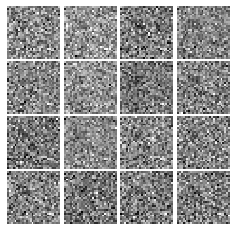


Iter: 20


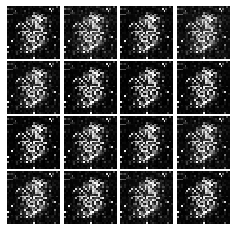


Iter: 40


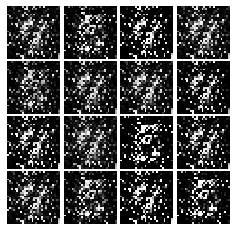


Iter: 60


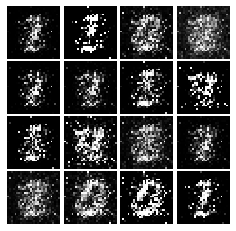


Iter: 80


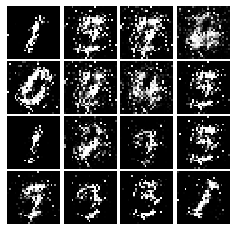


Iter: 100


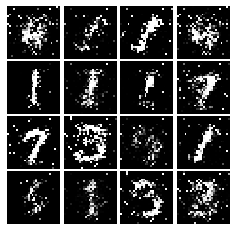


Iter: 120


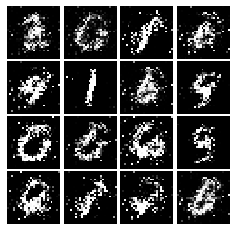


Iter: 140


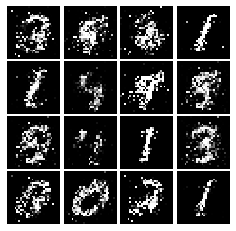


Iter: 160


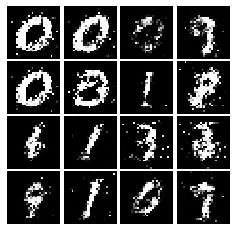


Iter: 180


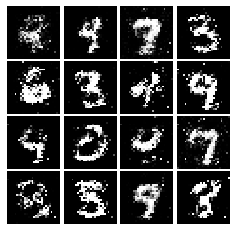


Iter: 200


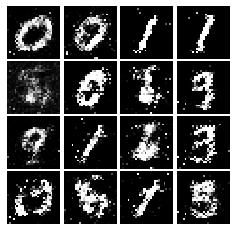


Iter: 220


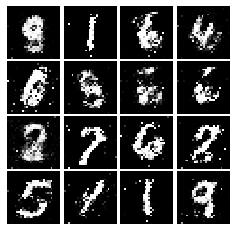


Iter: 240


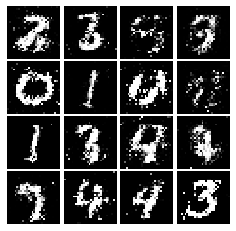


Iter: 260


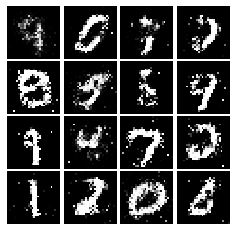


Iter: 280


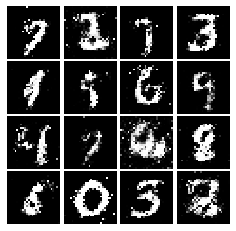


Iter: 300


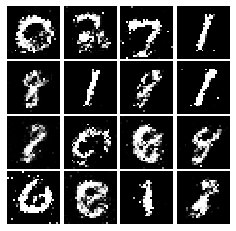


Iter: 320


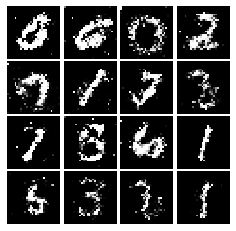


Iter: 340


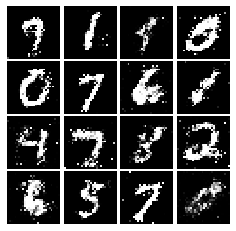


Iter: 360


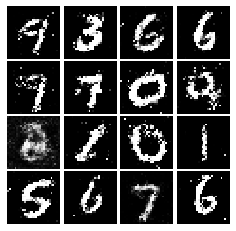

In [25]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 20
    print()
    


**提交时，请运行下面的单元格。**

LSGAN Final images


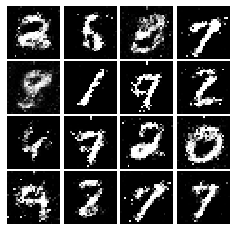

In [26]:
print('LSGAN Final images')
show_images(final)
plt.show()

# Deep Convolutional GANs
在这个 notebook 的开头部分，我们几乎完全照搬了 Ian Goodfellow 的最初始版本的 GAN 网络。然而这个网络的结构注定了生成的图片不具备空间合理性。它通常无法推理诸如“尖锐的边缘”之类的东西因为它没有卷积层。因此，在这小结，我们会去实现 [DCGAN](https://arxiv.org/abs/1511.06434) 中的一些想法，在实现的过程中我们会使用卷积神经网络。（[DCGAN 中文解释](https://blog.csdn.net/qq_33594380/article/details/84135797)）

#### 判别器
我们受 TensorFlow MNIST 分类[教程](https://www.tensorflow.org/get_started/mnist/pros)的启发，该分类器能够在 MNIST 数据集上相当快地达到99％以上的准确率。*检查 x 的维度，并在需要时 reshape*，全连接层（fc层）期望输入为 `[N,D]` Tensors，conv2d 层的期望输入为 `[N,H,W,C]` Tensors。请使用 `tf.keras.layers` 去定义以下结构的神经网络：

网络结构:
* Conv2D: 32 Filters, 5x5, Stride 1, padding 0
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1, padding 0
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

再次强调，请对所有卷积层和全连接层使用偏置项，并使用默认参数来初始化。 请注意，可以使用 'VALID' 填充选项将填充值设置为0。

在 `daseCV/gan_tf.py` 中完成 `dc_discriminator` 函数

In [27]:
from daseCV.gan_tf import dc_discriminator

# model = dc_discriminator()
test_discriminator(1102721, dc_discriminator)

Correct number of parameters in discriminator.


#### 生成器
对于生成器我们直接拷贝 [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf) 中的结构 （[InfoGAN paper简单解释](https://zhuanlan.zhihu.com/p/55945164)）。See Appendix C.1 MNIST。在写代码到时候请使用 `tf.keras.layers`。你也许会发现 [tf.keras.layers.Conv2DTranspose](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Conv2DTranspose) 这个文档很有用。网络结构如下：

网络结构:
* Fully connected with output size 1024 
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128 
* `ReLU`
* BatchNorm
* Resize into Image Tensor of size 7, 7, 128
* Conv2D^T (transpose): 64 filters of 4x4, stride 2
* `ReLU`
* BatchNorm
* Conv2d^T (transpose): 1 filter of 4x4, stride 2
* `TanH`

再次强调，对全连接层和转置卷积（反卷积）层使用偏置项。 请为你的参数使用默认的初始化方式。 对于 padding，请为转置卷积选择 'same' 选项。 对于Batch Normalization，假设我们始终处于 'training' 模式。

在 `daseCV/gan_tf.py` 中完成 `dc_generator` 函数

In [28]:
from daseCV.gan_tf import dc_generator


test_generator(6595521, generator=dc_generator)

Correct number of parameters in generator.


更改函数后，我们必须重新创建网络。

### Train and evaluate a DCGAN
这是作业3中使用 GPU 受益最显著的一部分。 在 GPU 上，训练5个回合只需要3分钟。 在使用 CPU 的双核笔记本电脑上大约需要50分钟（如果在CPU上使用，则可以只训练3回合）。

In [29]:
# Make the discriminator
D = dc_discriminator()

# Make the generator
G = dc_generator()

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver, G_solver = get_solvers()

# Run it!
images, final = run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, num_epochs=5)

Epoch: 0, Iter: 0, D: 1.333, G:0.6644
Epoch: 0, Iter: 250, D: 0.0002179, G:8.444
Epoch: 1, Iter: 500, D: 3.946e-05, G:10.19
Epoch: 1, Iter: 750, D: 2.287e-05, G:10.69
Epoch: 2, Iter: 1000, D: 1.392, G:0.9409
Epoch: 2, Iter: 1250, D: 1.248, G:3.202
Epoch: 3, Iter: 1500, D: 1.435, G:3.066
Epoch: 3, Iter: 1750, D: 0.6573, G:1.991
Epoch: 4, Iter: 2000, D: 0.09481, G:4.215
Epoch: 4, Iter: 2250, D: 0.499, G:2.289


Iter: 0


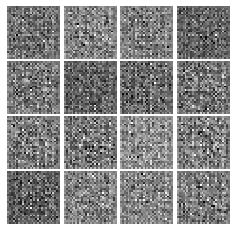


Iter: 20


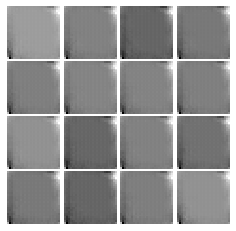


Iter: 40


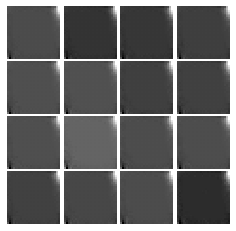


Iter: 60


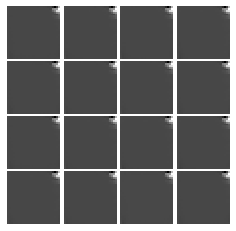


Iter: 80


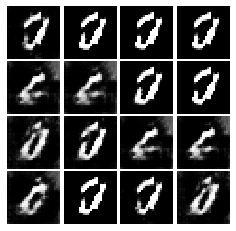


Iter: 100


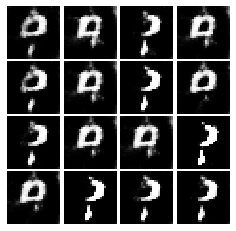


Iter: 120


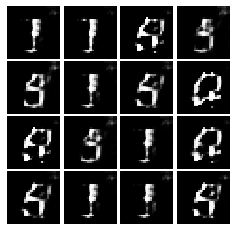


Iter: 140


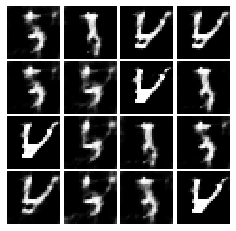


Iter: 160


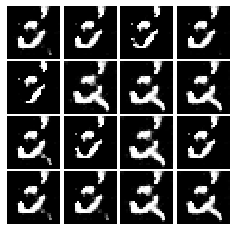


Iter: 180


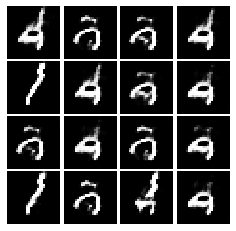

In [30]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 20
    print()
    

**提交时，请运行下面的单元格。**

DCGAN Final images


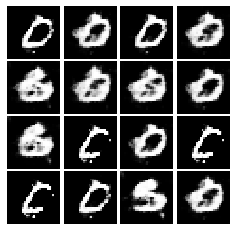

In [31]:
print('DCGAN Final images')
show_images(final)
plt.show()

## INLINE QUESTION 1

我们来看一个例子，看看为什么交替最小化同一目标（例如在GAN中）可能是棘手的事情。

考虑公式$f(x,y)=xy$。$\min_x\max_y f(x,y)$ 会出现什么结果？(Hint: minmax尝试最小化可能的最大值。)

现在我们尝试用6步去优化这个方程，设起始点为 $(1,1)$，step size 为 $1$(先更新 y， 然后用更新后的 y 更新 x)。**在这里 step size=learning_rate，learning_rate * gradient 为步长。**
你会发现用 $x_t,y_t,x_{t+1},y_{t+1}$ 写出中间步骤会有助于分析该问题。

简单解释 $\min_x\max_y f(x,y)$ 的计算结果并在下述表格中记录每一步 $(x_t,y_t)$ 的显式值。

### Your answer:
 
 $y_0$ | $y_1$ | $y_2$ | $y_3$ | $y_4$ | $y_5$ | $y_6$ 
 ----- | ----- | ----- | ----- | ----- | ----- | ----- 
   1   |   2   |   1   | -1    |   -2  |    -1 |  1     
 $x_0$ | $x_1$ | $x_2$ | $x_3$ | $x_4$ | $x_5$ | $x_6$ 
   1   |   -1  |   -2  |  -1   |   1   |   2   |    1   
   


## INLINE QUESTION 2
使用这种方法，我们能否达到最佳值？ 为什么能或者为什么不能？

### Your answer: 
不能。由上面的每一步的显式值可以看到很难收敛。

## INLINE QUESTION 3
如果在训练过程中生成器损失减少，而判别器损失从一开始就保持恒定的高值，这是一个好兆头吗？ 为什么或者为什么不？ 给一个定性的答案就好。

### Your answer: 
不是。因为生成器损失低意味着由它产生的数据会被判别器误判为真实数据。这两个损失减少应该是同步的，像这种生成器损失减少，判别器恒为高值的预测效果就不会太好。